# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file


# parameters

In [4]:
# _fname = "../replays/local.log"
_fname = "../replays/day1-log6.log"
_time_step = 100
_max_time = 100000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]

print("_fname", _fname)


_fname ../replays/day1-log6.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__game_state_start", end_sep="__game_state_end")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))


Reading from input file ../replays/day1-log6.log
num missing_times 2
missing_times [9800, 29100]


In [6]:
# load order info from file
obj = process_file(_fname, start_sep="__turn_end_start", end_sep="__turn_end_end")
raw_records = pd.DataFrame(obj)

Reading from input file ../replays/day1-log6.log


### add turns

In [7]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### book_tops

#### modify raw_df["book"] to be all ints

In [8]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [9]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []


In [10]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 998
Remaining count: 998
nan count: 0


In [11]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4897.0,4898.0,4897.5,1.0,10002.0,10004.0,10003.0,2.0,100
2,4892.0,4899.0,4895.5,7.0,9996.0,10004.0,10000.0,8.0,200
3,4898.0,4900.0,4899.0,2.0,9995.0,10005.0,10000.0,10.0,300
4,4894.0,4896.0,4895.0,2.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
993,4889.0,4896.0,4892.5,7.0,9995.0,9998.0,9996.5,3.0,99500
994,4889.0,4892.0,4890.5,3.0,9995.0,10005.0,10000.0,10.0,99600
995,4892.0,4896.0,4894.0,4.0,9995.0,10005.0,10000.0,10.0,99700


In [12]:
### flatt

In [13]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [14]:
def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

### dup trade filtering -> market_trades, my_trades, trade_df

In [15]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


### old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# # filter my_trades (only keep those where fill_time = order_time + 100)
# my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
### end of old filter methods

trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


### Ref EMA
- the EMA values that were calculated during the program

In [16]:
# ref_emas contains EMA values that were used during the program
ref_emas = raw_records["best_emas"].apply(pd.Series).round(2)
ref_emas = pd.concat([ref_emas, raw_records["time"]], axis=1)

### volume summary

In [17]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 217 	volume: 685
[MY]	 count: 131 	volume: 387
[MY]	 vol%: 36.1%
PEARLS
[THEM]	 count: 180 	volume: 379
[MY]	 count: 197 	volume: 489
[MY]	 vol%: 56.34%


### my_position validation

In [18]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["total_cash"] = 0
for sym in _symbols:
    cur_positions[f"{sym}_cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["total_cash"] += -1 * diff * price
        fixed_positions[f"{prod}_cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["total_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["total_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
for prod in ["total", *_products]:
    my_positions[f"{prod}_cash"] = pos_df[f"{prod}_cash"]
# my_positions["total_cash"] = pos_df["total_cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in _products:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['total_cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    # my_positions["total_cash"] = fixed_pos_df["total_cash"]
    for prod in ["total", *_products]:
        my_positions[f"{prod}_cash"] = fixed_pos_df[f"{prod}_cash"]

[Fixed trade] Turn: 229, time: 23000, PEARLS -1.0 @ 9999.0
true pos


,BANANAS,BANANAS_cash,PEARLS,PEARLS_cash,time,total_cash,turn
229,19.0,-92889.0,15.0,-159718.0,23000,-252607.0,229
230,19.0,-92889.0,15.0,-159718.0,23100,-252607.0,230
231,19.0,-92889.0,15.0,-159718.0,23200,-252607.0,231
232,19.0,-92889.0,15.0,-159718.0,23300,-252607.0,232
233,20.0,-97782.0,15.0,-159718.0,23400,-257500.0,233
...,...,...,...,...,...,...,...
993,6.0,-28840.0,5.0,-58812.0,99500,-87652.0,993
994,6.0,-28840.0,8.0,-88806.0,99600,-117646.0,994
995,7.0,-33732.0,8.0,-88806.0,99700,-122538.0,995
996,7.0,-33732.0,8.0,-88806.0,99800,-122538.0,996


calculated pos


,BANANAS,BANANAS_cash,PEARLS,PEARLS_cash,total_cash
229,19,-92889.0,16,-159718.0,-252607.0
230,19,-92889.0,16,-159718.0,-252607.0
231,19,-92889.0,16,-159718.0,-252607.0
232,19,-92889.0,16,-159718.0,-252607.0
233,20,-97782.0,16,-159718.0,-257500.0
...,...,...,...,...,...
993,6,-28840.0,6,-58812.0,-87652.0
994,6,-28840.0,9,-88806.0,-117646.0
995,7,-33732.0,9,-88806.0,-122538.0
996,7,-33732.0,9,-88806.0,-122538.0


Using fixed_pos_df['total_cash']


Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_6951/868700199.py", line 92, in <module>
    assert False, f"Failed check for product: `{prod}`"
AssertionError: Failed check for product: `PEARLS`


### Construct postbook
- Want to see what the world looked like, after we submit our orders

In [19]:
f_buy = lambda x : sorted(list(x.items()), reverse=True)
f_sell = lambda x : sorted(list(x.items()), reverse=False)
f_my_buy = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=True)
f_my_sell = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=False)

book = pd.merge(raw_df[["book", "time"]], raw_records, on="time")
new_book = book[["time"]].copy()

for sym in _symbols:
    new_book[f"{sym}_buys"] = book["book"].apply(lambda x : f_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_sells"] = book["book"].apply(lambda x : f_sell(x[sym]["sell_orders"]))
    new_book[f"{sym}_my_buys"] = book["my_orders"].apply(lambda x : f_my_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_my_sells"] = book["my_orders"].apply(lambda x : f_my_sell(x[sym]["sell_orders"]))

book = new_book


In [51]:
def get_book(sym, time):
    bk = book[book["time"] == time]
    
    if len(bk) == 0:
        print(f"No data for {sym} at time {time}")
        return None, None, None, None
    
    buys = bk[f"{sym}_buys"].iloc[0]
    sells = bk[f"{sym}_sells"].iloc[0]
    my_buys = bk[f"{sym}_my_buys"].iloc[0]
    my_sells = bk[f"{sym}_my_sells"].iloc[0]
    
    return buys, sells, my_buys, my_sells


def get_trades(sym, time):
    market_ts = market_trades[(market_trades["symbol"] == sym) & (market_trades["time"] == time)]
    my_ts = my_trades[(my_trades["symbol"] == sym) & (my_trades["time"] == time)]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
    my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, my_ts


def get_ref_ema(sym, time):
    return ref_emas.set_index("time").loc[time][sym]


def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    plt.figure(figsize=(15,6))
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    if buys is None:
        return
    market_ts, my_ts = get_trades(sym, time + _time_step)
    ref_ema = get_ref_ema(sym, time)
    
    f = lambda x : pd.DataFrame(x, columns=["price", "quantity"])
    
    buys, sells, my_buys, my_sells = f(buys), f(sells), f(my_buys), f(my_sells)
    
    # make bars have correct sign
    sells["quantity"] *= -1
    my_buys["quantity"] *= -1
    my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    
    ### draw reference lines
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    plt.axvline(x=ref_ema, color="black", linestyle='dotted')
    
    ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span}")
    plt.show()
    
    
    ### print raw info
    print("ref_ema", ref_ema)
    
    print("market trades")
    display(market_ts)
    print("my trades")
    display(my_ts)
    
    print("buys")
    display(buys.T)
    print("sells")
    display(sells.T)
    print("my_buys")
    display(my_buys.T)
    print("my_sells")
    display(my_sells.T)
    
    
    
def show_book_simple(
        sym,
        time=0,
        # ymin=None,
        # ymax=None,
        ):
    
    # all trades
    all_trades = trade_df[trade_df["symbol"] == sym]
    
    def flatten(col):
        return [el[0] for l in list(col) for el in l]
    
    # all orders
    market_buys = book[f"{sym}_buys"]
    market_sells = book[f"{sym}_sells"]
    my_buys = book[f"{sym}_my_buys"]
    my_sells = book[f"{sym}_my_sells"]
    # display(market_buys)
    # display(list(market_buys.apply(lambda x : [p for p, q in x])))
    
    # print(market_buys.apply(lambda x : x[))
    
    all_prices = [
        # all trades
        trade_df[trade_df["symbol"] == sym]["price"],
        # all orders
        flatten(market_buys),
        flatten(market_sells),
        flatten(my_buys),
        flatten(my_sells),
    ]
    
    xmin = min([min(x) for x in all_prices]) - 1
    xmax = max([max(x) for x in all_prices]) + 1
    
    show_book(
        sym, 
        time,
        xmin=xmin,
        xmax=xmax,
        ymin=-40,
        ymax=50,
    )

In [52]:
# hatched areas show trades
# bars show orders

# vertical red solid line - true mid price based on book
# vertical black dotted line - EMA (that the program used)


interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS"],
    time=(0, _max_time, _time_step),
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS'), value='BANANAS'), IntSlider(v…

<function __main__.show_book_simple(sym, time=0)>

# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [22]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,PEARLS
turn,,,
0,0,4896.0,10001.5
1,100,4897.5,10003.0
2,200,4895.5,10000.0
3,300,4899.0,10000.0
4,400,4895.0,10001.0
...,...,...,...
993,99500,4892.5,9996.5
994,99600,4890.5,10000.0
995,99700,4894.0,10000.0


### Estimate PNLs

In [23]:
# estimate pnl
cash_cols = [f"{prod}_cash" for prod in ["total", *_products]]
# cash_cols += [f"{sym}_cash" for sym in _symbols]

for prod in ["total", *_products]:
    my_positions[f"{prod}_pnl"] = my_positions[f"{prod}_cash"]

for prod in _products:
    col = f"{prod}_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]
    
    col = "total_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]


#### func -  plot_trades_and_book()

In [24]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5, label="mid")
    ax.set_title(f"Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5, label="mid")
    ax.set_title(f"(smooth) Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

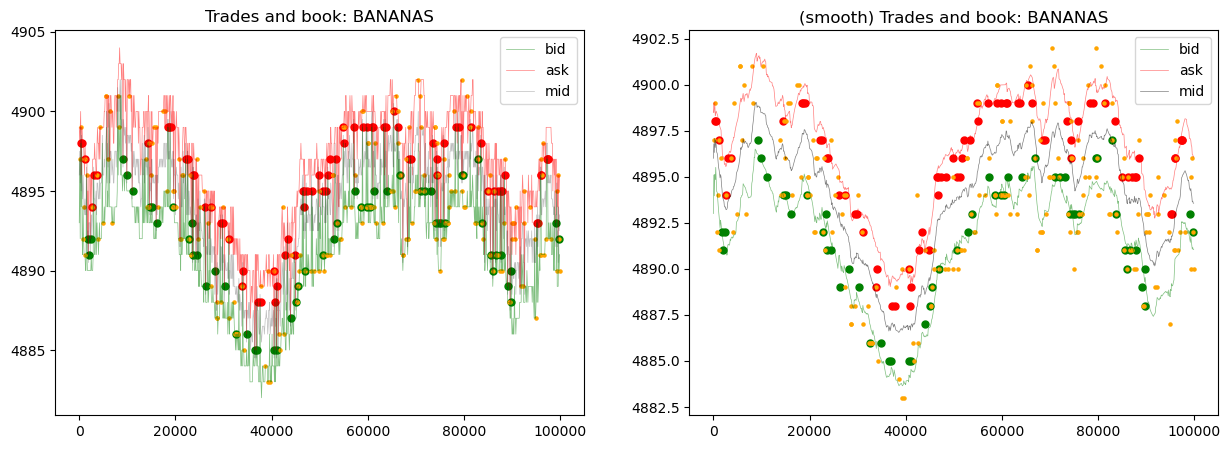

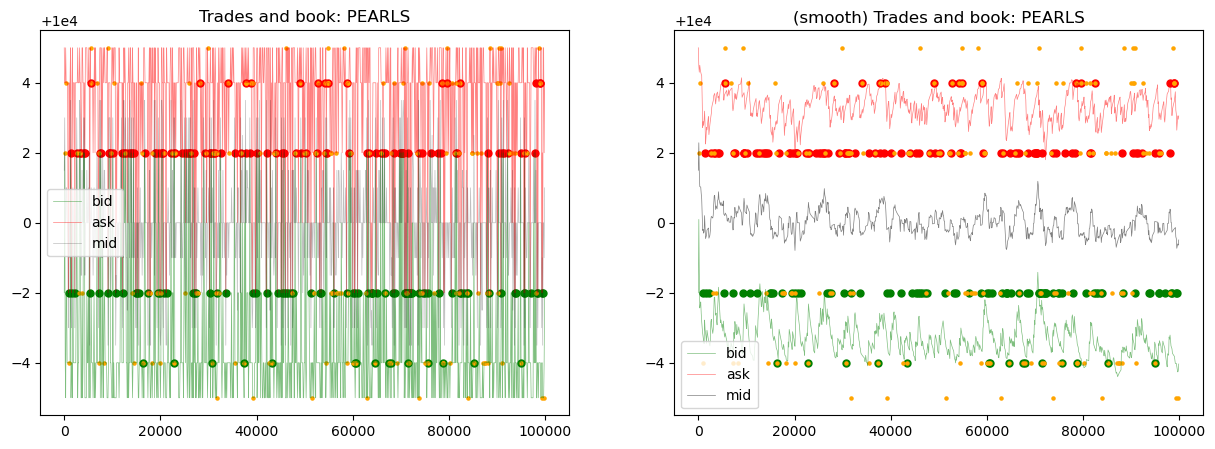

In [25]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    show_mid=True,
)
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    show_mid=True,
)


### compare ref EMA to true EMA

In [26]:
symbol = "BANANAS"
spans = raw_records["best_ema_spans"].apply(lambda x : x[symbol])
spans.value_counts()

21    995
Name: best_ema_spans, dtype: int64

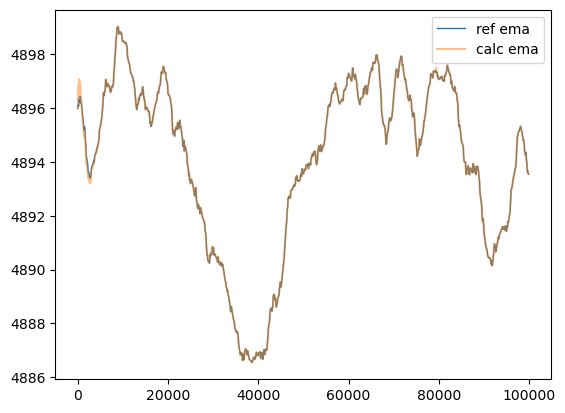

In [27]:
symbol = "BANANAS"

mids = book_tops[f"{symbol}_mid"]
ema = mids.ewm(span=21).mean()

plt.plot(ref_emas["time"], ref_emas["BANANAS"], label="ref ema", alpha=1, linewidth=1)
plt.plot(book_tops["time"], ema, label="calc ema", alpha=0.5)
plt.legend()

### PNL Graph

Text(0.5, 1.0, 'PNL')

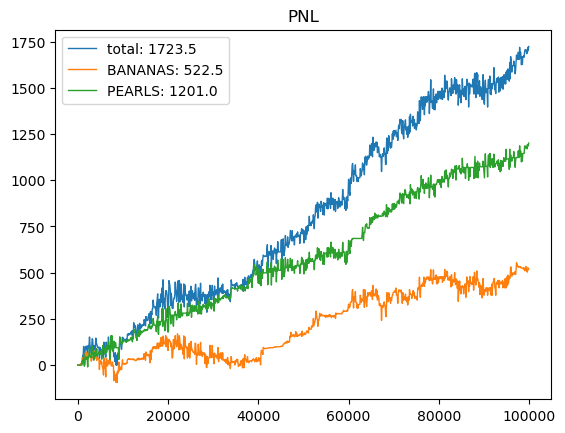

In [28]:
# pnl
for prod in ["total", *_products]:
    pnl = my_positions[f"{prod}_pnl"].iloc[-1]
    plt.plot(my_positions["time"], my_positions[f"{prod}_pnl"], label=f"{prod}: {pnl}", linewidth=1)
    
plt.legend()
plt.title(f"PNL")


In [29]:
# print pnl per product


### Positions Graph

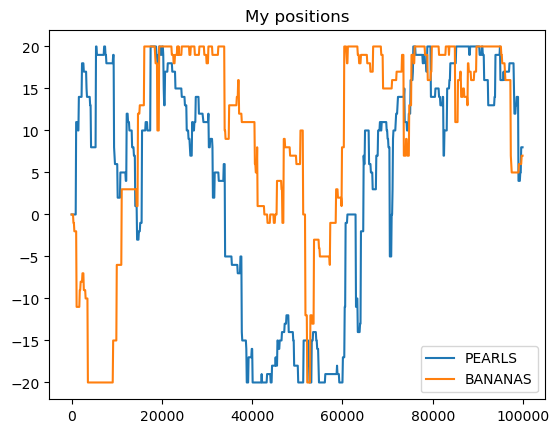

In [30]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

### Price movements (pct change)

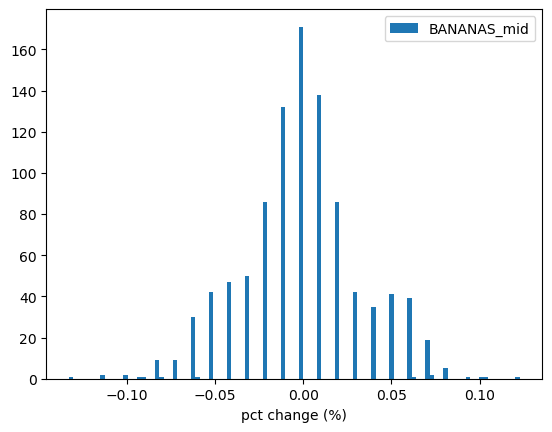

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,997.0,-0.000045,0.034499,-0.132734,-0.020423,0.0,0.020425,0.122687


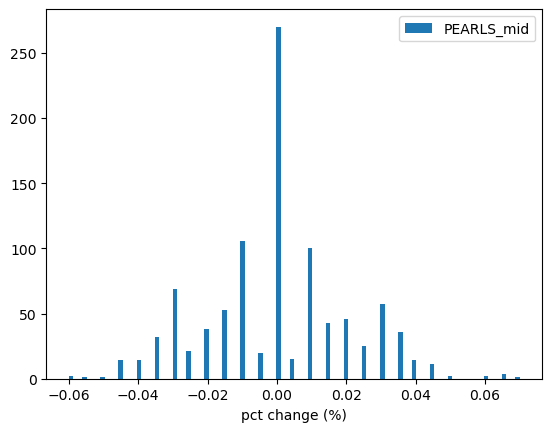

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,997.0,-0.000003,0.02112,-0.059982,-0.010002,0.0,0.010001,0.070025


In [31]:
# distribution of price movements (pct change)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) / col).dropna()
    diffs = (diffs - 1) * 100
    plt.hist(diffs, bins=100, label=mid)
    plt.xlabel("pct change (%)")
    plt.legend()
    plt.show()
    display(diffs.describe().T)

### Price movements (actual change)

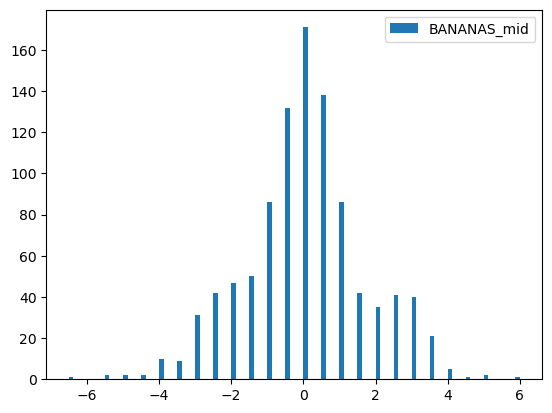

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,997.0,-0.002508,1.688386,-6.5,-1.0,0.0,1.0,6.0


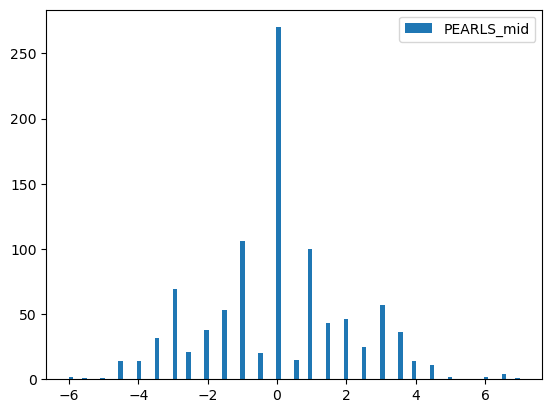

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,997.0,-0.000502,2.112011,-6.0,-1.0,0.0,1.0,7.0


In [32]:
# distribution of price movements (actual #)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) - col).dropna()
    plt.hist(diffs, bins=100, label=mid)
    plt.legend()
    plt.show()
    display(diffs.describe().T)


### Spread stats - BANANAS

In [33]:
# spread summary stats

sym = "BANANAS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,998.0,5.250501,1.947499,1.0,5.0,6.0,7.0,7.0


### Spread stats - PEARLS

In [34]:
# spread summary stats

sym = "PEARLS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,998.0,6.672345,2.550956,2.0,6.0,8.0,8.0,10.0


In [35]:
# 
trade_df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,469.0,4.136461,4.333646,1.0,1.0,1.0,1.0,2.0,5.0,11.0,19.0,21.0


## Trade analysis - BANANAS

#### func - calc_rtns()

In [36]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]
    
    # exclude trades during "closing time"
    cutoff_time = _max_time - _num_close_turns * _time_step
    df = df[df["time"] < cutoff_time]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



#### func - blur()

In [37]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

### Rtn over time

total prof 762.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,126.0,-0.138889,1.374975,-2.5,-1.0,-0.5,-0.5,5.5
rtn_0,126.0,1.968254,1.197908,-1.5,1.5,2.0,2.5,5.5
rtn_1,126.0,1.829365,1.443832,-2.0,1.0,2.0,2.5,6.0
rtn_3,126.0,2.035714,1.568666,-2.5,1.5,2.0,3.0,6.0
rtn_10,126.0,1.968254,1.919110,-2.0,0.5,2.0,3.0,6.5
rtn_30,126.0,1.849206,2.683483,-6.0,-0.5,2.0,4.0,7.5
rtn_100,126.0,1.781746,4.317173,-8.5,-1.5,1.5,4.5,11.5


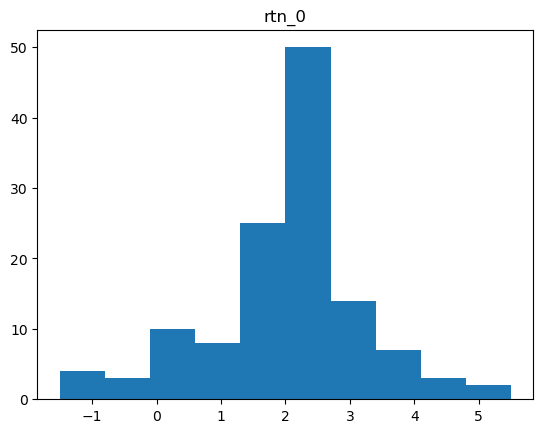

In [38]:
# summary stats for trades vs rtns

sym = "BANANAS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])
plt.title("rtn_0")

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

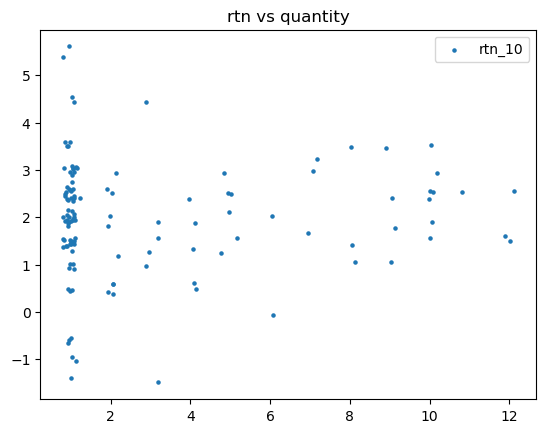

In [39]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_10")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### large trades

In [40]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
big_days = sizes[sizes["quantity"] >= 15]
df[df["time"].isin(big_days.index)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
44,SUBMISSION,4885.0,5,,BANANAS,40500,40600,404,True,True,...,4895.5,9999.0,-0.5,1.5,4.0,2.0,2.5,3.5,10.5,7.5
45,,4890.0,10,SUBMISSION,BANANAS,40500,40600,404,True,False,...,4895.5,9999.0,5.5,3.5,1.0,3.0,2.5,1.5,-5.5,35.0


### losers: trade/book graph

In [41]:
losers = df[(df["rtn_10"] < 0)]
winners = df[df["rtn_10"] > 0]

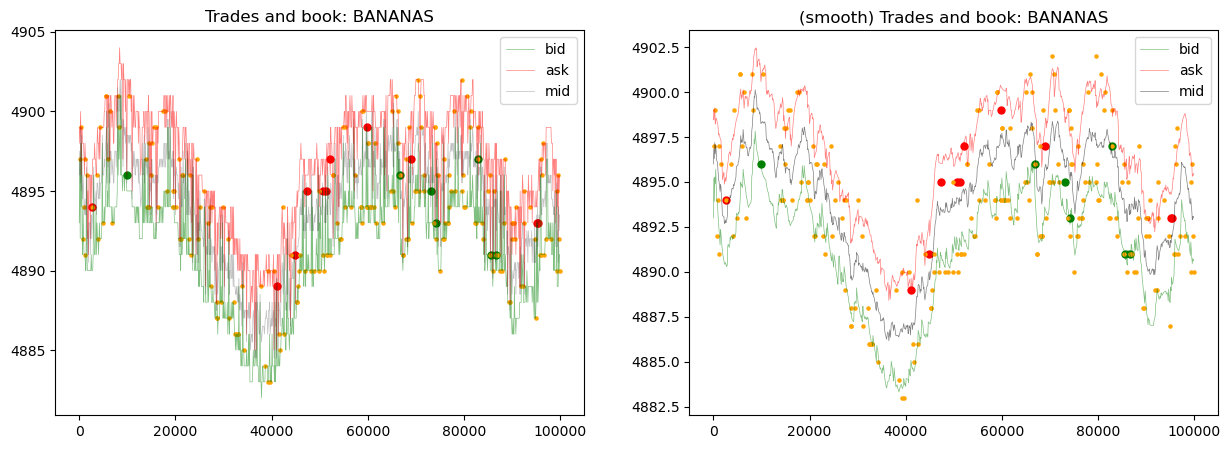

In [42]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=2e5, 
    span=10,
    show_mid=True,
)


In [43]:
losers

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
6,,4894.0,2,SUBMISSION,BANANAS,2600,2700,27,True,False,...,4894.0,10001.0,2.0,1.0,0.5,-2.5,-1.5,-6.0,-0.0,2.0
10,SUBMISSION,4896.0,9,,BANANAS,9900,10000,99,True,True,...,4893.5,9996.5,-0.5,2.5,2.5,2.0,-1.5,-1.5,-2.5,22.5
48,,4889.0,7,SUBMISSION,BANANAS,41100,41200,410,True,False,...,4896.0,10000.0,-0.5,1.5,1.5,1.0,-1.5,-0.5,-7.0,10.5
52,,4891.0,1,SUBMISSION,BANANAS,44700,44800,446,True,False,...,4896.0,10000.0,-1.0,0.5,0.5,0.5,-2.0,-2.5,-5.0,0.5
59,,4895.0,1,SUBMISSION,BANANAS,47200,47300,471,True,False,...,4897.0,10000.0,-0.5,2.0,1.5,2.0,-1.0,1.5,-2.0,2.0
62,,4895.0,1,SUBMISSION,BANANAS,50600,50700,505,True,False,...,4897.0,10001.5,-0.5,1.0,1.0,2.0,-1.5,-0.5,-2.0,1.0
64,,4895.0,10,SUBMISSION,BANANAS,51200,51300,511,True,False,...,4896.5,10000.0,-1.0,2.0,1.0,1.5,-0.5,-0.0,-1.5,20.0
66,,4897.0,8,SUBMISSION,BANANAS,52100,52200,520,True,False,...,4895.5,10001.0,3.0,3.5,1.5,2.5,-1.0,-0.5,1.5,28.0
76,,4899.0,1,SUBMISSION,BANANAS,59700,59800,596,True,False,...,4897.5,10000.0,-1.0,2.0,2.0,2.5,-0.5,3.0,1.5,2.0
87,SUBMISSION,4896.0,3,,BANANAS,66700,66800,666,True,True,...,4895.5,9998.5,1.0,-1.5,-1.5,-1.5,-1.0,1.5,-0.5,-4.5


## Trade analysis - PEARLS

### rtn over time

total prof 977.5


,count,mean,std,min,25%,50%,75%,max
rtn_-1,188.0,-0.244681,2.057651,-1.5,-1.50,-1.0,-1.000,7.0
rtn_0,188.0,2.095745,1.659161,-1.5,1.00,2.0,3.000,7.0
rtn_1,188.0,2.183511,1.714080,-1.5,1.00,2.0,3.000,7.0
rtn_3,188.0,2.199468,1.930296,-1.5,1.00,2.0,3.125,7.5
rtn_10,188.0,2.582447,1.626933,-1.5,2.00,2.0,4.000,7.0
rtn_30,188.0,2.356383,1.656493,-1.5,2.00,2.0,3.000,7.5
rtn_100,188.0,2.332447,1.701638,-1.5,1.75,2.0,3.500,7.5


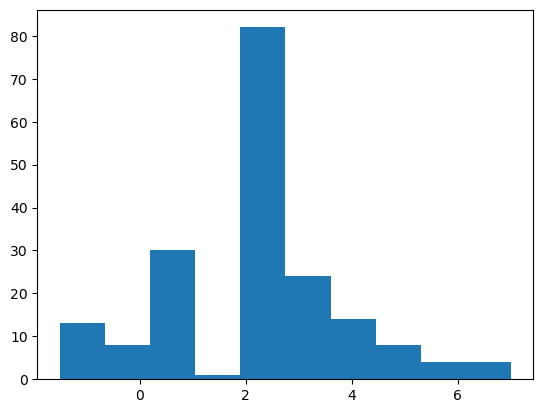

In [44]:
### summary stats for trades vs rtns

sym = "PEARLS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

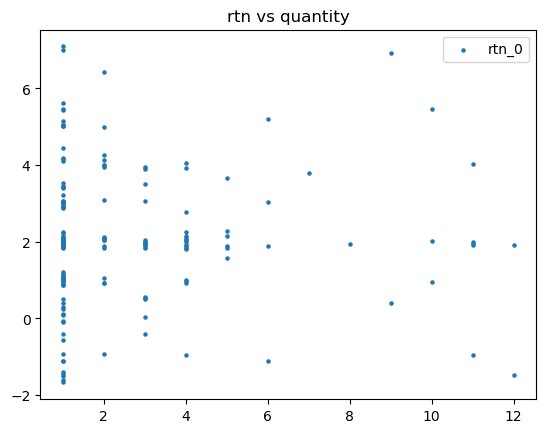

In [45]:
plt.scatter(blur(df["quantity"], std=0.0), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### losers: rtn0 vs spread

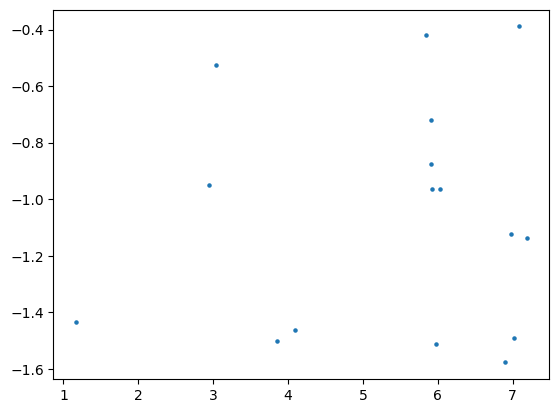

In [46]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

df = pd.merge(losers, book_tops[["BANANAS_spread", "time"]].shift(1), on="time")
plt.scatter(blur(df["BANANAS_spread"]), blur(df["rtn_0"]), s=5)

In [47]:
losers.describe().T

,count,mean,std,min,25%,50%,75%,max
price,16.0,10000.25000,2.049390,9998.0,9998.000,10002.00,10002.000,10002.0
quantity,16.0,3.00000,3.614784,1.0,1.000,1.00,3.250,12.0
order_time,16.0,40637.50000,26750.722732,3200.0,20125.000,32600.00,70400.000,72100.0
time,16.0,40737.50000,26750.722732,3300.0,20225.000,32700.00,70500.000,72200.0
turn,16.0,406.06250,266.774929,33.0,201.250,325.50,703.000,720.0
my_quantity,16.0,-1.25000,4.582576,-12.0,-1.250,-1.00,1.000,6.0
BANANAS_-1,16.0,4896.34375,2.925285,4887.0,4895.750,4896.50,4898.500,4899.0
PEARLS_-1,16.0,10000.75000,3.033150,9997.0,9997.000,10003.00,10003.000,10003.5
BANANAS_0,16.0,4895.87500,3.500000,4886.0,4894.375,4896.00,4898.625,4900.0
PEARLS_0,16.0,10000.46875,3.180507,9996.5,9997.375,10003.00,10003.000,10003.5


### losers: histogram of price changes

(array([ 5., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ]),
 <BarContainer object of 10 artists>)

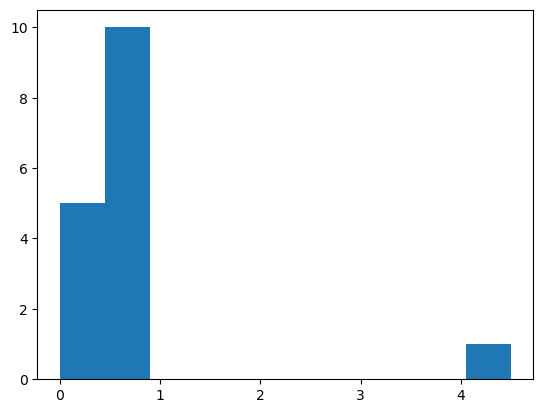

In [48]:
loser_diffs = (abs(losers["PEARLS_-1"] - losers["PEARLS_0"]))

plt.hist(loser_diffs)

### losers: trade/book graph

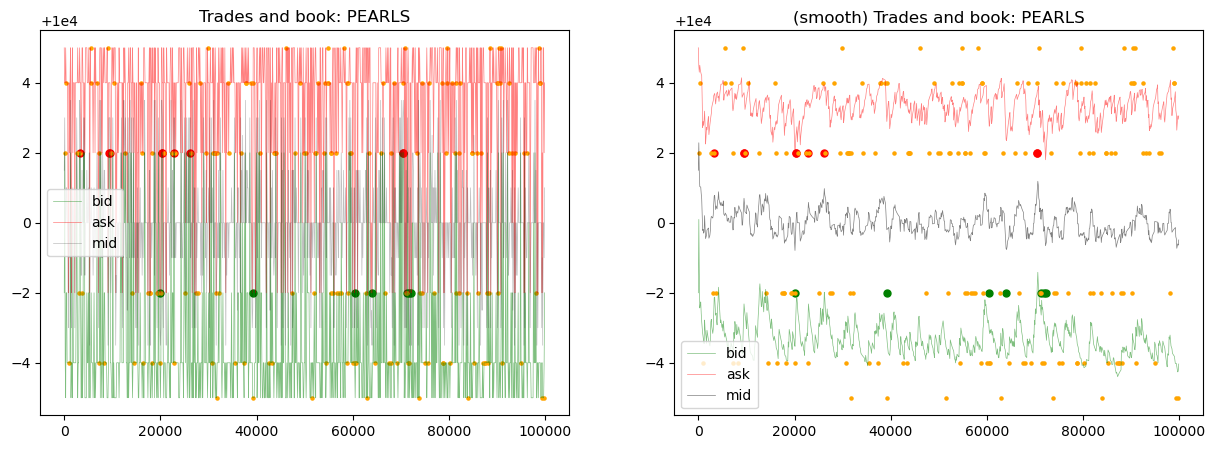

In [49]:
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=200000, 
    span=21,
    show_mid=True,
)
